In [1]:
import numpy as np
from utils.lattice_utils import plot_lattice
import os
from utils.mat_utils import frac_to_cart_coords, get_pbc_cutoff_graphs, lattice_params_to_matrix_torch
import torch


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 22 14:27:22 2024

@author: zj1283
"""

import numpy as np
import matplotlib.pyplot as plt

def visualizeLattice(nodes, struts, save_dir=None, dpi=150):
    """
    Visualize the lattice structure from the specified file.
    
    Parameters:
        save_dir (str): Path to the file containing node and strut data.
        dpi (int): Dots per inch setting for the plot resolution.
        (dpi represents dots per inch, number can be adjusted based on the need)
    """
    
    # Initialize containers for nodes and struts

    # Plot the lattice structure
    fig = plt.figure(dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Set the title using the file name
    
    ax.set_title(save_dir)

    # Customize background color
    ax.set_facecolor((1, 1, 1))  # Light gray background
    ax.grid(True)

    # Plot nodes with a solid color (e.g., yellow with black edge)
    ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2], c='yellow', edgecolor='black', s=30)

    # Plot struts with a solid color (e.g., blue)
    for strut in struts:
        start_node = nodes[strut[0], :]
        end_node = nodes[strut[1], :]
        ax.plot([start_node[0], end_node[0]], 
                [start_node[1], end_node[1]], 
                [start_node[2], end_node[2]], 'b-', linewidth=1)

    #set the elevation (elev) and azimuth (azim) angles of the plot
    ax.view_init(elev=10, azim=30)  # these numbers can be adjust to shown figures with different viewing perspective
    
    # # Turn off the grid
    # ax.grid(False)
    if save_dir is not None:
        plt.savefig(save_dir)
    plt.show()

# # Example usage
#visualizeLattice('unit cell/octet.txt')


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  3 22:15:04 2024

@author: zj1283
"""

import numpy as np
import matplotlib.pyplot as plt

def visualizeVox(voxel):
    # Generate binary voxel data
    voxel_data = voxel
    
    # Create a 3D plot
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    
    # Get the coordinates of the voxels
    dimensions = voxel.shape
    x, y, z = np.indices(dimensions)
    
    # Plot the voxels
    ax.voxels(voxel_data)
    
    #set the elevation (elev) and azimuth (azim) angles of the plot
    ax.view_init(elev=25, azim=30)  # these numbers can be adjust to shown figures with different viewing perspective
    
    # Set labels
    ax.set_xlabel('voxel X')
    ax.set_ylabel('voxel Y')
    ax.set_zlabel('voxel Z')
    
    # Turn off the grid
    #ax.grid(False)
    
    # Show the plot
    plt.show()

# Example use
#from visualize_voxel import visualizeVox; 
#visualizeVox(voxel)

In [4]:
# -*- coding: utf-8 -*-
"""
Code translated from Matlab scirpt
"""

import numpy as np

def generate_voxel(n, node, strut, radius):
    """
    Generate a voxel grid and calculate the relative density.
    
    Parameters:
        n (int): Number of voxels along each axis.
        address (str): File location of the wireframe.
        radius (float): Radius for determining active voxels.
        
    Returns:
        tuple: Voxel grid (3D numpy array) and density (float).
    """
    size = 1.0 / n               # initial size of voxels
    voxel = np.zeros((n, n, n))  # initial grid with zeros

    # Generate a list of centers of voxel
    voxel_c = np.zeros((n**3, 6))
    p = 0                        # p count the number of all voxels
    for i in range(1, n + 1):    # i for z axis
        for j in range(1, n + 1):# j for y axis
            for k in range(1, n + 1): # k for x axis
                p += 1
                voxel_c[p-1, 0:3] = [k, j, i]  # save index along x,y,z axis
                # save coordinate along x,y,z axis
                voxel_c[p-1, 3:6] = [(k-0.5)*size, (j-0.5)*size, (i-0.5)*size]         

    # Get the voxel close to the strut within a certain distance
    # node, strut = read_strut(address)  # get the information of strut
    for i in range(len(voxel_c)):      # for each voxel, decide if it is active
        center = voxel_c[i, 3:6]       # voxel center position
        for j in range(len(strut)):    # for each strut, get the distance to the voxel
            start_n = node[strut[j, 0] - 1, :]  # start node coordinate
            end_n = node[strut[j, 1] - 1, :]    # end node coordinate

            # determine if alpha and beta are acute angles
            alpha = np.degrees(np.arccos(np.dot((center - start_n), (end_n - start_n)) / 
                                        (np.linalg.norm(center - start_n) * np.linalg.norm(end_n - start_n))))
            beta = np.degrees(np.arccos(np.dot((center - end_n), (start_n - end_n)) / 
                                       (np.linalg.norm(center - end_n) * np.linalg.norm(start_n - end_n))))

            if alpha < 90 and beta < 90:  # if not acute angle, distance to line
                distance = np.linalg.norm(np.cross(end_n - start_n, center - start_n)) / np.linalg.norm(end_n - start_n)
            else:                         # if it is acute angle, distance to node
                distance = min(np.linalg.norm(center - start_n), np.linalg.norm(center - end_n))
            
            if distance <= radius:        # if distance less than radius, activate it
                voxel[int(voxel_c[i, 0]) - 1, int(voxel_c[i, 1]) - 1, int(voxel_c[i, 2]) - 1] = 1
                break  # move to the next voxel

    density = np.sum(voxel) / n**3  # calculate the relative density
    return voxel, density

def read_strut(address):
    """
    Import information of strut from a file.
    
    Parameters:
        address (str): File location of the wireframe.
    
    Returns:
        tuple: Node list (2D numpy array) and strut list (2D numpy array).
    """
    nodelist = []
    strutlist = []
    
    with open(address, 'r') as file:
        for line in file:
            if line.startswith('N'):
                x = float(line[16:24])
                y = float(line[24:32])
                z = float(line[32:40])
                nodelist.append([x, y, z])
            elif line.startswith('S'):
                Snode = int(line[16:24])
                Enode = int(line[24:32])
                strutlist.append([Snode, Enode])
    
    return np.array(nodelist), np.array(strutlist)

In [5]:
def post_process_9(input_coords,alpha=1):
    #input_coords shape: 9*3
    lattice = np.random.random(12)
    loss = cal_lattice_loss(lattice,input_coords)
    for _ in range(2000):
        #step = np.random.random(12) * 0.1
        step = np.zeros(12)
        index = np.random.randint(0,12)
        step[index] = np.random.random() * 0.1
        temp_loss = cal_lattice_loss(lattice+step,input_coords)
        #print(temp_loss-loss)
        if temp_loss < loss:
            #print(temp_loss)
            lattice += step
            loss = temp_loss
    return alpha*get_coords_from_lattice(lattice)+(1-alpha)*input_coords,get_connection_9()

def cal_lattice_loss(hypothesis_lattice,input_coords):
    #hypo_lattice: shape 12, (center coord, axis1 vector, axis2 vector, axis3 vector)
    hypo_coords = get_coords_from_lattice(hypothesis_lattice)
    index_mask = np.ones(9)
    loss = 0
    for i in range(9):
        temp_loss = np.inf
        for j in range(9):
            if index_mask[j] > 0:
                if np.linalg.norm(hypo_coords[i]-input_coords[j]) < temp_loss:
                    #temp_loss = np.sum((hypo_coords[i]-input_coords[j])**2)
                    #temp_loss = 1.0/np.linalg.norm(hypo_coords[i]-input_coords[j])
                    temp_loss = np.linalg.norm(hypo_coords[i]-input_coords[j])
                    temp_index = j
        index_mask[temp_index] = 0
        loss += temp_loss
    
    return 0.5*loss + 1/sin_vec(hypothesis_lattice[3:6],hypothesis_lattice[6:9])\
    + 1/sin_vec(hypothesis_lattice[3:6],hypothesis_lattice[9:])\
    + 1/sin_vec(hypothesis_lattice[6:9],hypothesis_lattice[9:])
    #return loss

def get_coords_from_lattice(lattice):
    coords = np.zeros((9,3))
    coords[0] = lattice[:3]
    coords[1] = lattice[:3] + lattice[3:6]/2 + lattice[6:9]/2 + lattice[9:]/2
    coords[2] = lattice[:3] + lattice[3:6]/2 + lattice[6:9]/2 - lattice[9:]/2
    coords[3] = lattice[:3] + lattice[3:6]/2 - lattice[6:9]/2 + lattice[9:]/2
    coords[4] = lattice[:3] + lattice[3:6]/2 - lattice[6:9]/2 - lattice[9:]/2
    coords[5] = lattice[:3] - lattice[3:6]/2 + lattice[6:9]/2 + lattice[9:]/2
    coords[6] = lattice[:3] - lattice[3:6]/2 + lattice[6:9]/2 - lattice[9:]/2
    coords[7] = lattice[:3] - lattice[3:6]/2 - lattice[6:9]/2 + lattice[9:]/2
    coords[8] = lattice[:3] - lattice[3:6]/2 - lattice[6:9]/2 - lattice[9:]/2
    return coords

def get_connection_9():
    connection = []
    edge1 = np.random.random() > 0.
    edge2 = np.random.random() > 0.
    edge3 = np.random.random() > 0.
    edge1 = True
    edge2 = True
    edge3 = True
    if not edge1 and not edge2 and not edge3:
        edge1 = True
    for i in range(8):
        connection.append([4,i])
    if edge1:
        for i in range(4):
            connection.append([i,i+4])
    if edge2:
        connection.append([1,3])
        connection.append([2,4])
        connection.append([5,7])
        connection.append([6,8])
    if edge3:
        connection.append([1,2])
        connection.append([3,4])
        connection.append([5,6])
        connection.append([7,8])
    return connection

def sin_vec(v1,v2):
    return np.sqrt(1-(np.dot(v1,v2)/np.linalg.norm(v1)/np.linalg.norm(v2))**2)

In [6]:
def plot_origin_lattice_from_path(path, name, cutoff=1.0,max_num_neighbors_threshold=3, save_dir=None):
    full_path = os.path.join(path,name)
    lattice_npz = np.load(full_path)
    frac_coords = lattice_npz['origin_frac_coords']
    lengths = lattice_npz['origin_lengths']
    angles = lattice_npz['origin_angles']
    atom_types = lattice_npz['origin_atom_types']
    num_atoms = torch.tensor([atom_types.shape[0]])
    frac_coords, lengths, angles = torch.from_numpy(frac_coords),torch.from_numpy(lengths), torch.from_numpy(angles)
    print(lengths,angles)
    cart_coords = frac_to_cart_coords(frac_coords,lengths,
                                      angles, num_atoms)
    print('num_atoms', num_atoms)
    try:
        # raise Exception
        edge_index = lattice_npz['origin_edge_index']
    except:
        edge_index, _,_ = get_pbc_cutoff_graphs(cart_coords, lengths, angles, num_atoms, cutoff=cutoff, max_num_neighbors_threshold=max_num_neighbors_threshold)
    print('edge_index \n', edge_index)
    plot_lattice(cart_coords,edge_index.T, save_dir=save_dir)

In [9]:
def plot_lattice_from_path(path, name, cutoff=1.0,max_num_neighbors_threshold=3, save_dir=None ):
    full_path = os.path.join(path,name)
    print(full_path)
    lattice_npz = np.load(full_path)
    frac_coords = lattice_npz['frac_coords']
    lengths = lattice_npz['lengths']
    angles = lattice_npz['angles']
    atom_types = lattice_npz['atom_types']
    num_atoms = torch.tensor([atom_types.shape[0]])
    frac_coords, lengths, angles = torch.from_numpy(frac_coords),torch.from_numpy(lengths).unsqueeze(0), torch.from_numpy(angles).unsqueeze(0)
    cart_coords = frac_to_cart_coords(frac_coords,lengths,
                                      angles, num_atoms)
    # cart_coords = frac_coords
    print(lengths, angles)
    print('num_atoms', num_atoms)
    print(frac_coords)
    # try:
    # raise Exception
    edge_index = lattice_npz['edge_index']
    # edge_index = np.array(get_connection_9()).T
    print('edge_index \n', edge_index)

    
    # except:
        # edge_index, _,_ = get_pbc_cutoff_graphs(cart_coords, lengths, angles, num_atoms, cutoff=cutoff, max_num_neighbors_threshold=max_num_neighbors_threshold)
    # try:
    #     print('Properteis: ', lattice_npz['prop_list'])
    #     print('mean:', lattice_npz['prop_list'].mean(), '\nvar:', lattice_npz['prop_list'].std())
    # except:
    #     pass
    
    frac_coords -= frac_coords.min()
    frac_coords /= (frac_coords.max() - frac_coords.min())
    
    plot_lattice(frac_coords,edge_index.T, save_dir=save_dir)

    visualizeLattice(frac_coords, edge_index.T, save_dir=save_dir)
    voxel, density= generate_voxel(100, frac_coords.numpy(), edge_index.T, 0.01)
    print('density is ', density)
    visualizeVox(voxel)
    




generated_mat/47node\LatticeStiffness_lattice_0.npz
tensor([[5.7292, 5.7454, 5.5548]]) tensor([[90.4040, 91.4732, 91.9274]])
num_atoms tensor([47])
tensor([[-5.0442e-02, -3.5805e-01, -1.5665e-01],
        [-2.6180e-01,  1.9277e-01, -1.2755e-01],
        [-5.7622e-02, -3.4076e-01, -8.6932e-02],
        [-2.6234e-01,  2.2075e-01, -6.5474e-02],
        [-1.6785e-01, -3.2476e-02, -7.2567e-03],
        [-1.7751e-01,  1.1973e-02,  1.2189e-01],
        [-7.9538e-02, -2.4653e-01,  1.7206e-01],
        [-2.8378e-01,  3.1767e-01,  2.0071e-01],
        [-8.1261e-02, -2.2766e-01,  2.4127e-01],
        [-2.9174e-01,  3.3457e-01,  2.6580e-01],
        [ 2.9215e-01, -3.3286e-01, -2.6947e-01],
        [ 7.7558e-02,  2.2509e-01, -2.4263e-01],
        [ 2.8264e-01, -3.1283e-01, -2.0273e-01],
        [ 7.4054e-02,  2.5286e-01, -1.7501e-01],
        [ 1.7448e-01, -8.0277e-03, -1.2157e-01],
        [ 1.6682e-01,  4.3176e-02,  6.8601e-03],
        [ 2.6483e-01, -2.2835e-01,  5.8449e-02],
        [ 6.0783e-0

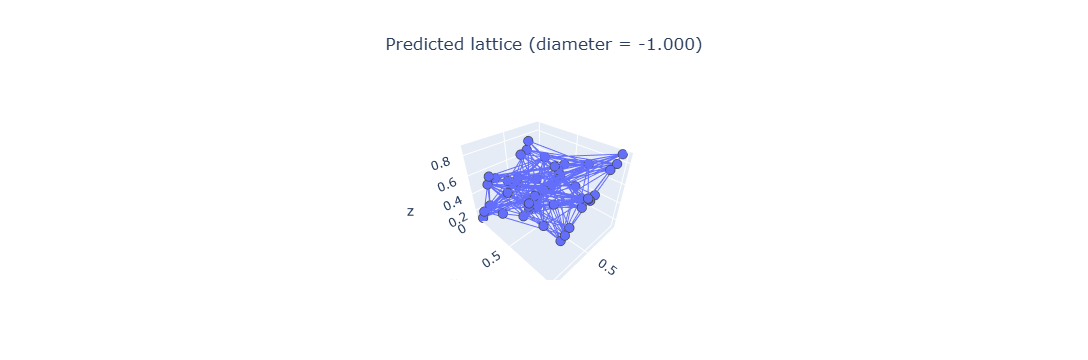

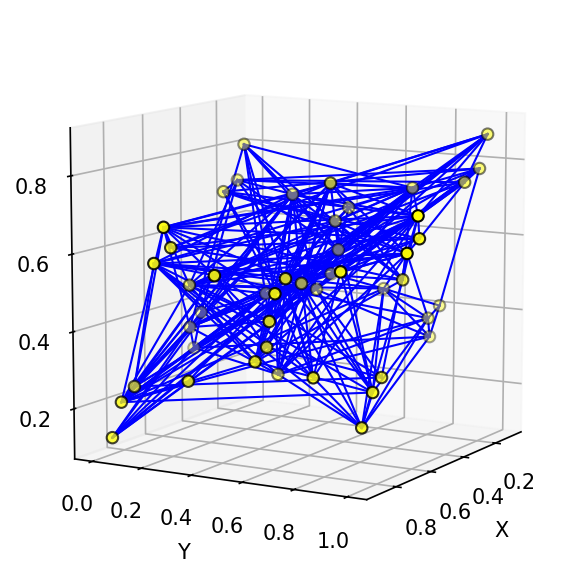

In [ ]:
path = 'generated_mat/47node'
name = 'LatticeStiffness_lattice_0.npz'
# plot_origin_lattice_from_path(path,name)
plot_lattice_from_path(path, name)

In [36]:
path = 'generated_mat/not_decomp'
name = 'LatticeStiffness_lattice_0.npz'

generated_mat/node_num9_pos2\LatticeStiffness_lattice_50.npz
num_atoms tensor([9])
Properteis:  [ 1.02595035e-02  3.20859207e-03  3.28204012e-03 -4.91347164e-05
 -7.81614799e-05 -3.73979565e-05  1.01773776e-02  3.41012934e-03
  1.69798732e-05  1.08455541e-04 -4.70527448e-05  1.00974794e-02
 -1.57783739e-04  5.29079698e-05  1.03705097e-05  3.25799221e-03
 -6.53935131e-05  6.17350452e-06  3.30868713e-03  5.22094779e-05
  3.28934332e-03]
mean: 0.0023858722 
var: 0.003494158


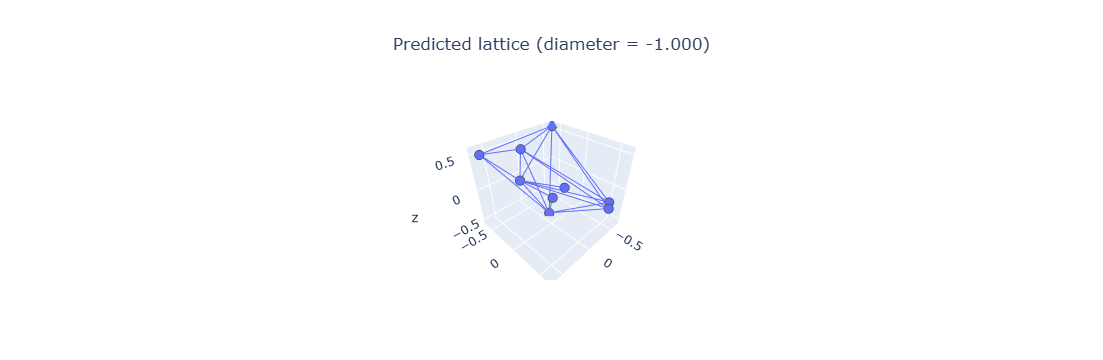

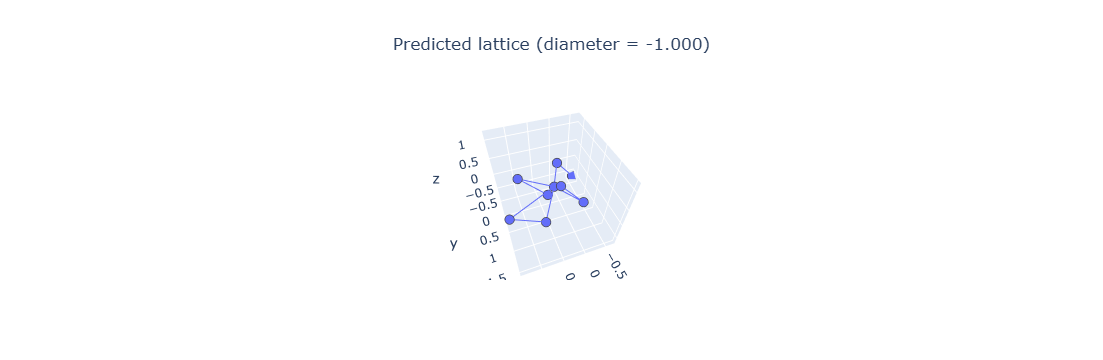

In [38]:
full_path = os.path.join(path,name)
print(full_path)
lattice_npz = np.load(full_path)
frac_coords = lattice_npz['frac_coords']
lengths = lattice_npz['lengths']
angles = lattice_npz['angles']
atom_types = lattice_npz['atom_types']
num_atoms = torch.tensor([atom_types.shape[0]])
frac_coords, lengths, angles = torch.from_numpy(frac_coords),torch.from_numpy(lengths).unsqueeze(0), torch.from_numpy(angles).unsqueeze(0)
cart_coords = frac_to_cart_coords(frac_coords,lengths,
                                  angles, num_atoms)
# cart_coords = frac_coords
print('num_atoms', num_atoms)
try:
    print('Properteis: ', lattice_npz['prop_list'])
    print('mean:', lattice_npz['prop_list'].mean(), '\nvar:', lattice_npz['prop_list'].std())
except:
    pass
try:
        # raise Exception
    edge_index = lattice_npz['edge_index']
except:
    print('Compute PBC edges')
    edge_index, _,_ = get_pbc_cutoff_graphs(cart_coords, lengths, angles, num_atoms, cutoff=cutoff, max_num_neighbors_threshold=max_num_neighbors_threshold)
# print('edge_index \n', edge_index)
plot_lattice(cart_coords, edge_index.T)

lattice_vector = lattice_params_to_matrix_torch(lengths, angles)
a = cart_coords.numpy()
ppa, edges = post_process_9(a,0.9)
edges = np.array(edges)
plot_lattice(ppa,edges)


generated_mat/15node\LatticeStiffness_lattice_1.npz
tensor([[3.9813, 3.8890, 3.8276]]) tensor([[90.2635, 90.2572, 90.2953]])
num_atoms tensor([15])
tensor([[ 4.3350e-02, -1.9691e-01,  1.6218e-01],
        [ 3.8648e-01, -4.6192e-02,  9.0052e-02],
        [ 1.1810e-02,  1.7734e-01, -4.4029e-01],
        [-3.3023e-01,  2.5445e-02, -3.6830e-01],
        [-1.3524e-02, -1.7698e-01,  4.3664e-01],
        [ 3.2828e-01, -2.3151e-02,  3.6632e-01],
        [-4.3234e-02,  1.9640e-01, -1.6271e-01],
        [-3.8508e-01,  4.7141e-02, -9.2165e-02],
        [ 1.8710e-01, -1.1057e-01,  2.6610e-01],
        [-1.8807e-01,  1.1272e-01, -2.6530e-01],
        [-1.7286e-01, -7.7457e-02,  3.3769e-02],
        [ 1.7116e-01,  7.6168e-02, -3.6773e-02],
        [ 2.8007e-02, -9.4533e-03, -1.3857e-01],
        [-2.8415e-02,  1.1839e-02,  1.3622e-01],
        [ 1.1193e-03,  6.9715e-04, -2.2173e-04]])
edge_index 
 [[ 0  1  0  2  0  1  4  2  5  3  4  6  0  1  4  5  2  3  6  7  0  3  4  7
   8  9  1  2  5  6  8  9  0 

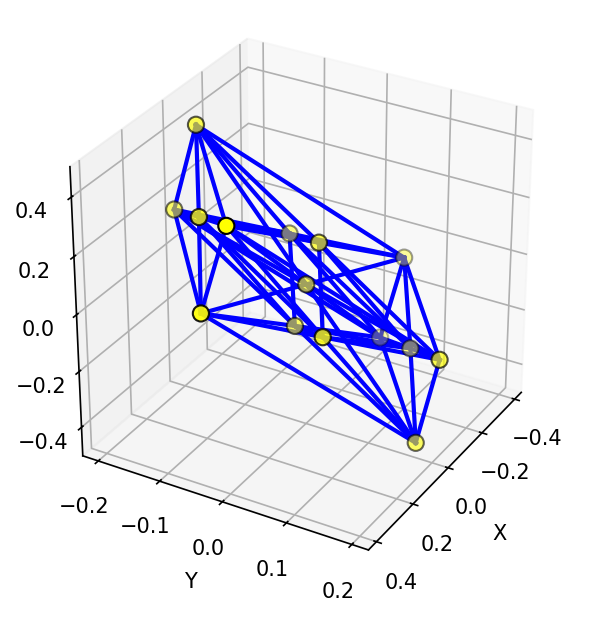

TypeError: 'float' object cannot be interpreted as an integer

In [39]:
path = 'generated_mat/15node'
name = 'LatticeStiffness_lattice_1.npz'
# plot_origin_lattice_from_path(path,name)
plot_lattice_from_path(path, name)

In [96]:
# exceed_num = 0
# for i in range(100):
#     name = 'LatticeStiffness_lattice_{}.npz'.format(i)
#     full_path = os.path.join(path,name)
#     print(full_path)
#     lattice_npz = np.load(full_path)
#     frac_coords = lattice_npz['frac_coords']
#     if np.any(frac_coords < -0.5) or np.any(frac_coords>0.5):
#         exceed_num += 1
# print(exceed_num)

In [108]:
path = 'generated_mat/step50_varProp=0.01_2'
name = 'LatticeStiffness_lattice_3.npz'
plot_lattice_from_path(path, name)

generated_mat/step50_varProp=0.01_2\LatticeStiffness_lattice_3.npz
tensor([[1.5529, 1.5434, 1.5500]]) tensor([[90.6170, 90.6836, 89.1461]])
num_atoms tensor([12])
edge_index 
 tensor([[ 6,  8, 10,  5,  7,  8,  5,  7, 11,  6,  7, 11,  0,  2,  9,  1,  2,  7,
          0,  3,  8,  2,  3,  5,  0,  1,  6,  1,  2,  4,  0,  3, 11,  2,  3, 10],
        [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
          6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11]])
Properteis:  [-0.0043955  -0.00286257  0.00374456  0.00170943  0.00566356 -0.00448935
 -0.01409014  0.00767925 -0.00132937  0.00528254 -0.01024122  0.00230721
 -0.00261539  0.00208655 -0.00095623  0.00457684 -0.00131458  0.00750923
  0.00620548  0.00138706 -0.00071043]
mean: 0.00024509183 
var: 0.005455087


In [ ]:
path = 'recon_mat/result_nequip_w_latents_1'
name = 'LatticeStiffness_lattice_2.npz'
plot_lattice_from_path(path, name)

In [89]:
path = 'recon_mat/result_nequip_w_latents/'
name = 'LatticeStiffness_lattice_5.npz'
plot_lattice_from_path(path, name)
plot_origin_lattice_from_path(path, name)

recon_mat/result_nequip_w_latents/LatticeStiffness_lattice_5.npz
tensor([[2.2646, 0.9836, 1.3413]]) tensor([[ 90.0833, 102.3676,  85.2879]])
num_atoms tensor([9])
edge_index 
 [[0 0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 5 5 6 7]
 [1 2 4 5 3 4 6 3 4 7 4 8 5 6 7 8 6 7 8 8]]
Properteis:  -0.00405043
mean: -0.00405043 
var: 0.0


tensor([[2.3680, 0.4856, 1.6928]]) tensor([[ 89.7049, 101.5294,  83.9811]])
num_atoms tensor([9])
edge_index 
 [[0 0 0 0 1 1 1 2 2 2 3 3 4 4 4 4 5 5 6 7]
 [1 2 4 5 3 4 6 3 4 7 4 8 5 6 7 8 6 7 8 8]]
